In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression, Perceptron
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
import optuna.integration.sklearn

In [2]:
all_new = pd.read_csv('data/feature_df.csv')
wordvec_df = pd.read_csv('sub_notebook/data/wordvectorized_df.csv')
bert_embeded = pd.read_csv('kaggle-notebook/data/bert_embeded.csv')
#tfidf_1000 = pd.read_csv('data/tfidf_1000.csv')
tfidf_svd_raw_64 = pd.read_csv("data/tfidf_svd_raw_64.csv")
#tfidf_svd_content_64 = pd.read_csv("data/tfidf_svd_content_64.csv")
#tfidf_svd_compiled_64 = pd.read_csv("data/tfidf_svd_compiled_64.csv")
mfw_df = pd.read_csv('data/mfw.csv')
miw_df = pd.read_csv('data/miw.csv')

In [3]:
#all_new = pd.merge(all_new, bert_embeded, on="id", how="outer")
all_new = pd.merge(all_new, tfidf_svd_raw_64, on="id", how="outer")
all_new = pd.merge(all_new, wordvec_df, on="id", how="outer")
all_new = pd.merge(all_new, miw_df, on="id", how="outer")
all_new = pd.merge(all_new, mfw_df.drop(["mfw", "sfw"], axis=1), on="id", how="outer")

In [4]:
test_set = all_new[all_new["data_type"] == "test"]
train_set= all_new[all_new["data_type"] == "train"]

In [5]:
with open("data/lgbm_config_svd64_raw.json") as f:
    optuna_config_dict = json.load(f)

target_cols = ["state"]
feature_cols = optuna_config_dict["selected_feature"]
CATEGORICAL_COLS = [
    "country",
    "category1",
    "category2",
    "country+category1",
    "country+category2",
    "category1+category2",
]

for categorical_col in set(CATEGORICAL_COLS):
    if categorical_col in feature_cols:
        feature_cols.remove(categorical_col)

In [6]:
def run_optuna_sklearn_clf(clf, param_distributions, test, train, target_cols, feature_cols, categorical_cols):
    """
    import optuna.integration.sklearn
    """
    
    X_train = train[feature_cols]
    y_train = train[target_cols]
    X_test = test[feature_cols]
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(X_train),))
    importances = []
    
    cv = KFold(n_splits=5, shuffle=True, random_state=456)
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
        X_tr = X_train.loc[train_index]
        X_val = X_train.loc[valid_index]
        y_tr = y_train.loc[train_index].values.ravel()
        y_val = y_train.loc[valid_index].values.ravel()
        
        optuna_search = optuna.integration.OptunaSearchCV(clf,
                                                          param_distributions,
                                                          n_jobs=4,
                                                          n_trials=50,
                                                          )
        optuna_search.fit(X_tr, y_tr)
        try:
            oof_train[valid_index] = optuna_search.predict_proba(X_val)[:,1]
            y_pred = optuna_search.predict_proba(X_test)[:,1]
        except:
            oof_train[valid_index] = optuna_search.predict(X_val)[:,1]
            y_pred = optuna_search.predict(X_test)[:,1]

        y_preds.append(y_pred)
        #models.append(optuna_search)

    return oof_train, sum(y_preds) / len(y_preds)

In [11]:
clf = Perceptron(max_iter=1000, )
param_distributions = {
    'alpha': optuna.distributions.UniformDistribution(0.00001, 0.001),
}

oof, preds = run_optuna_sklearn_clf(clf, param_distributions, test_set, train_set, target_cols, feature_cols, CATEGORICAL_COLS)

<ipython-input-6-3b452e689da4>:22: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(clf,
[I 2021-01-28 00:29:42,753] A new study created in memory with name: no-name-667c13cb-9536-491e-9d46-f1003f6d1a4e
[I 2021-01-28 00:29:43,246] Trial 1 finished with value: 0.5723157572403408 and parameters: {'alpha': 0.0008752741101095403}. Best is trial 1 with value: 0.5723157572403408.
[I 2021-01-28 00:29:43,289] Trial 2 finished with value: 0.5723157572403408 and parameters: {'alpha': 0.00012388561707085008}. Best is trial 1 with value: 0.5723157572403408.
[I 2021-01-28 00:29:43,291] Trial 0 finished with value: 0.5723157572403408 and parameters: {'alpha': 0.0009820952514113831}. Best is trial 1 with value: 0.5723157572403408.
[I 2021-01-28 00:29:43,318] Trial 3 finished with value: 0.5723157572403408 and parameters: {'alpha': 0.0003226870433581337}. Best is trial 1 with value:

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [9]:
def optimize_threshold(oof, y_train):
    best_score = 0
    scores = []
    ratios = []
    for thr in np.arange(0, 1.0, 0.025):
        oof_ = np.where(oof<thr, 0, 1)
        ratio = np.count_nonzero(oof_>0)/len(oof_)
        ratios.append(ratio)
        f1score = f1_score(y_true=y_train, y_pred=oof_,average='binary', sample_weight=None, zero_division='warn')
        scores.append(f1score)
        best_score = max(best_score, f1score)
        if f1score == best_score:
            best_threshold = thr
    plt.figure()
    plt.title('f1_score')
    plt.scatter(np.arange(0, 1.0, 0.025), scores)
    plt.scatter(np.arange(0, 1.0, 0.025), ratios)
    return best_score, best_threshold

0.7554940582777144 0.375


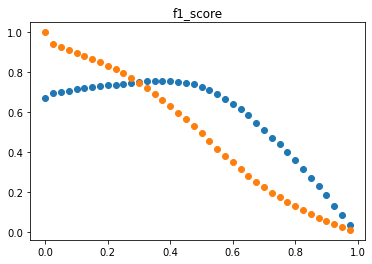

In [10]:
best_score, best_threshold = optimize_threshold(oof, list(train_set["state"]))
print(best_score, best_threshold)